# Evaluation using QCB chemicals (small)

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from os.path import exists

sys.path.append('../..')

In [3]:
import pylab as plt
import pandas as pd
import numpy as np
from loguru import logger
import seaborn as sns
import copy

from stable_baselines3 import DQN, PPO
from sb3_contrib import RecurrentPPO

In [4]:
from vimms.Common import POSITIVE, set_log_level_warning, load_obj, save_obj
from vimms.ChemicalSamplers import UniformRTAndIntensitySampler, GaussianChromatogramSampler, UniformMZFormulaSampler, \
    MZMLFormulaSampler, MZMLRTandIntensitySampler, MZMLChromatogramSampler
from vimms.Noise import UniformSpikeNoise
from vimms.Evaluation import evaluate_real
from vimms.Chemicals import ChemicalMixtureFromMZML
from vimms.Roi import RoiBuilderParams, SmartRoiParams

from mass_spec_utils.data_import.mzmine import load_picked_boxes

from vimms_gym.env import DDAEnv
from vimms_gym.chemicals import generate_chemicals
from vimms_gym.evaluation import evaluate, run_method
from vimms_gym.common import METHOD_RANDOM, METHOD_FULLSCAN, METHOD_TOPN, METHOD_DQN, \
    METHOD_DQN_COV, METHOD_DQN_INT, METHOD_DQN_MID, METHOD_PPO, METHOD_PPO_RECURRENT

# 1. Parameters

Parameters that will be used throughout this notebook. Should be the same as the training ones.

Chemical generation parameters

In [5]:
from experiments import preset_qcb_small
alpha = 0.50
beta = 0.75
extract = False
params, max_peaks = preset_qcb_small(None, alpha=alpha, beta=beta, extract_chromatograms=extract)
params, max_peaks

2022-08-22 13:26:52.970 | INFO     | experiments:get_samplers:238 - Loaded /Users/joewandy/Work/git/vimms-gym/pickles/samplers_QCB_small_gaussian.p


({'chemical_creator': {'mz_range': (100, 110),
   'rt_range': (400, 500),
   'intensity_range': (10000.0, 1e+20),
   'n_chemicals': (20, 50),
   'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7f8bed7fb520>,
   'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7f8bed7fbaf0>,
   'cr_sampler': <vimms.ChemicalSamplers.GaussianChromatogramSampler at 0x7f8ba80ec6a0>},
  'noise': {'enable_spike_noise': True,
   'noise_density': 0.1,
   'noise_max_val': 1000.0,
   'mz_range': (100, 110)},
  'env': {'ionisation_mode': 'Positive',
   'rt_range': (400, 500),
   'isolation_window': 0.7,
   'mz_tol': 10,
   'rt_tol': 120,
   'alpha': 0.5,
   'beta': 0.75}},
 100)

In [6]:
# n_chemicals = (20, 50)
# mz_range = (100, 110)
# rt_range = (400, 500)
# intensity_range = (1E4, 1E20)

Evaluation parameters

In [7]:
env_name = 'DDAEnv'
intensity_threshold = 0.5
max_peaks = 100
in_dir = '../../tune/QCB_chems_small'
out_dir = 'evaluation'
methods = [
    METHOD_RANDOM,
    # METHOD_PPO,
    # METHOD_PPO_RECURRENT,
    # METHOD_DQN,        
    METHOD_DQN_COV,            
    METHOD_DQN_INT,                
    METHOD_TOPN,
]
n_eval_episodes = 3

In [8]:
# topN parameters
topN_N = 5
topN_rt_tol = 5
min_ms1_intensity = 5000

# smartroi parameters
alpha = 2
beta = 1
smartroi_N = topN_N
smartroi_dew = topN_rt_tol

# weighteddew parameters
t0 = 3
t1 = 120
weighteddew_N = 10

## Generate chemical sets for evaluation

In [9]:
fname = 'QCB_chems_small.p'
found = exists(fname)
if found:
    chem_list = load_obj(fname)
    for chems in chem_list:
        print(len(chems))

28
22
45
28
20
38
34
21
37
45
36
46
49
24
32
42
25
34
44
37
23
40
43
37
27
32
34
26
28
34


Generate new chemicals if not found

In [10]:
if not found:
    repeat = 30
    logger.warning('Generating chemicals')
    min_mz = mz_range[0]
    max_mz = mz_range[1]
    min_rt = rt_range[0]
    max_rt = rt_range[1]
    min_log_intensity = np.log(intensity_range[0])
    max_log_intensity = np.log(intensity_range[1])
    
    mzml_filename = '../fullscan_QCB.mzML'
    logger.info('Creating samplers from %s' % mzml_filename)
    mz_sampler = MZMLFormulaSampler(mzml_filename, min_mz=min_mz, max_mz=max_mz)
    ri_sampler = MZMLRTandIntensitySampler(mzml_filename, min_rt=min_rt, max_rt=max_rt,
                                           min_log_intensity=min_log_intensity,
                                           max_log_intensity=max_log_intensity)
    
    # roi_params = RoiBuilderParams(min_roi_length=3, at_least_one_point_above=1000)
    # cr_sampler = MZMLChromatogramSampler(mzml_filename, roi_params=roi_params)
    cr_sampler = GaussianChromatogramSampler()
    
    chemical_creator_params = {
        'mz_range': mz_range,
        'rt_range': rt_range,
        'intensity_range': intensity_range,
        'n_chemicals': n_chemicals,
        'mz_sampler': mz_sampler,
        'ri_sampler': ri_sampler,
        'cr_sampler': cr_sampler
    }

    chem_list = []
    for i in range(repeat):
        chems = generate_chemicals(chemical_creator_params)
        print(len(chems))
        chem_list.append(chems)
        
    save_obj(chem_list, fname)

In [11]:
chem_list = chem_list[0:n_eval_episodes]
len(chem_list)

3

# 2. Evaluation

In [12]:
set_log_level_warning()

1

In [13]:
params

{'chemical_creator': {'mz_range': (100, 110),
  'rt_range': (400, 500),
  'intensity_range': (10000.0, 1e+20),
  'n_chemicals': (20, 50),
  'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7f8bed7fb520>,
  'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7f8bed7fbaf0>,
  'cr_sampler': <vimms.ChemicalSamplers.GaussianChromatogramSampler at 0x7f8ba80ec6a0>},
 'noise': {'enable_spike_noise': True,
  'noise_density': 0.1,
  'noise_max_val': 1000.0,
  'mz_range': (100, 110)},
 'env': {'ionisation_mode': 'Positive',
  'rt_range': (400, 500),
  'isolation_window': 0.7,
  'mz_tol': 10,
  'rt_tol': 120,
  'alpha': 0.5,
  'beta': 0.75}}

In [14]:
method_eval_results = {}
for method in methods:

    N = 0
    copy_params = copy.deepcopy(params)           
    custom_objects = {
        "learning_rate": 0.0,
        "lr_schedule": lambda _: 0.0,
        "clip_range": lambda _: 0.0,
    }    
    
    if method == METHOD_DQN:
        alpha = 0.50
        beta = 0.75
        model_dir = os.path.join(in_dir, 'metric_reward_timesteps_200000_alpha_%.2f_beta_%.2f' % (alpha, beta), METHOD_DQN)
        fname = os.path.join(model_dir, 'best_model.zip')
        model = DQN.load(fname, custom_objects=custom_objects)
        copy_params['env']['alpha'] = alpha
        copy_params['env']['beta'] = beta                
    elif method == METHOD_DQN_COV:
        alpha = 0.75
        beta = 0.75
        model_dir = os.path.join(in_dir, 'metric_reward_timesteps_200000_alpha_%.2f_beta_%.2f' % (alpha, beta), METHOD_DQN)
        fname = os.path.join(model_dir, 'best_model.zip')
        model = DQN.load(fname, custom_objects=custom_objects)
        copy_params['env']['alpha'] = alpha
        copy_params['env']['beta'] = beta                        
    elif method == METHOD_DQN_INT:
        alpha = 0.25
        beta = 0.75
        model_dir = os.path.join(in_dir, 'metric_reward_timesteps_200000_alpha_%.2f_beta_%.2f' % (alpha, beta), METHOD_DQN)
        fname = os.path.join(model_dir, 'best_model.zip')
        model = DQN.load(fname, custom_objects=custom_objects)
        copy_params['env']['alpha'] = alpha
        copy_params['env']['beta'] = beta                        
    elif method == METHOD_PPO:
        alpha = 0.50
        beta = 0.75
        model_dir = os.path.join(in_dir, 'metric_reward_timesteps_200000_alpha_%.2f_beta_%.2f' % (alpha, beta), METHOD_PPO)        
        fname = os.path.join(model_dir, 'best_model.zip')
        model = PPO.load(fname, custom_objects=custom_objects)
        copy_params['env']['alpha'] = alpha
        copy_params['env']['beta'] = beta                
    elif method == METHOD_PPO_RECURRENT:
        alpha = 0.50
        beta = 0.75
        model_dir = os.path.join(in_dir, 'metric_reward_timesteps_200000_alpha_%.2f_beta_%.2f' % (alpha, beta), METHOD_PPO_RECURRENT)        
        fname = os.path.join(model_dir, 'best_model.zip')        
        model = RecurrentPPO.load(fname, custom_objects=custom_objects)
        copy_params['env']['alpha'] = alpha
        copy_params['env']['beta'] = beta                
    else:
        model = None
        if method == METHOD_TOPN:
            N = topN_N
            effective_rt_tol = topN_rt_tol
            copy_params['env']['rt_tol'] = effective_rt_tol                        

    banner = 'method = %s max_peaks = %d N = %d rt_tol = %d' % (method, max_peaks, N, copy_params['env']['rt_tol'])
    print(banner)
    print()            
            
    episodic_results = run_method(env_name, copy_params, max_peaks, chem_list, method, out_dir, 
                                  N=N, min_ms1_intensity=min_ms1_intensity, model=model,
                                  print_eval=True, print_reward=True, intensity_threshold=intensity_threshold,
                                  mzml_prefix=method)
    eval_results = [er.eval_res for er in episodic_results]
    method_eval_results[method] = eval_results
    print()

method = random max_peaks = 100 N = 0 rt_tol = 120


Episode 0 (28 chemicals)
Finished after 491 timesteps with total reward -455.5067101468663
recalculated_coverage_prop 0.2857142857142857 evaluated_coverage_prop 0.5357142857142857
recalculated_intensity_prop 0.17529172244273347 evaluated_intensity_prop 0.3667143128252336
{'coverage_prop': '0.286', 'intensity_prop': '0.175', 'ms1ms2_ratio': '0.019', 'efficiency': '0.031', 'TP': '5', 'FP': '3', 'FN': '20', 'precision': '0.625', 'recall': '0.200', 'f1': '0.303', 'total_rewards': -455.5067101468664}

Episode 1 (22 chemicals)
Finished after 489 timesteps with total reward -445.96827109066214
recalculated_coverage_prop 0.36363636363636365 evaluated_coverage_prop 0.8181818181818182
recalculated_intensity_prop 0.3168046236074142 evaluated_intensity_prop 0.6904304375241168
{'coverage_prop': '0.364', 'intensity_prop': '0.317', 'ms1ms2_ratio': '0.023', 'efficiency': '0.038', 'TP': '8', 'FP': '0', 'FN': '14', 'precision': '1.000', 'recall': '0.3

/opt/anaconda3/envs/vimms-gym/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:561: UserWarning:

This system does not have apparently enough memory to store the complete replay buffer 0.99GB > 0.32GB

/opt/anaconda3/envs/vimms-gym/lib/python3.9/site-packages/stable_baselines3/dqn/dqn.py:152: UserWarning:

The number of environments used is greater than the target network update interval (20 > 1), therefore the target network will be updated after each call to env.step() which corresponds to 20 steps.



Finished after 250 timesteps with total reward 25.0
recalculated_coverage_prop 0.0 evaluated_coverage_prop 0.0
recalculated_intensity_prop 0.0 evaluated_intensity_prop 0.0
{'coverage_prop': '0.000', 'intensity_prop': '0.000', 'ms1ms2_ratio': '0.000', 'efficiency': '0.000', 'TP': '0', 'FP': '0', 'FN': '28', 'precision': '0.000', 'recall': '0.000', 'f1': '0.000', 'total_rewards': 25.000000000000085}

Episode 1 (22 chemicals)
Finished after 250 timesteps with total reward 25.0
recalculated_coverage_prop 0.0 evaluated_coverage_prop 0.0
recalculated_intensity_prop 0.0 evaluated_intensity_prop 0.0
{'coverage_prop': '0.000', 'intensity_prop': '0.000', 'ms1ms2_ratio': '0.000', 'efficiency': '0.000', 'TP': '0', 'FP': '0', 'FN': '22', 'precision': '0.000', 'recall': '0.000', 'f1': '0.000', 'total_rewards': 25.000000000000085}

Episode 2 (45 chemicals)
Finished after 250 timesteps with total reward 25.0
recalculated_coverage_prop 0.0 evaluated_coverage_prop 0.0
recalculated_intensity_prop 0.0 eva

#### Test classic controllers in ViMMS

In [15]:
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import TopNController, TopN_SmartRoiController, WeightedDEWController
from vimms.Environment import Environment

Run Top-N Controller

In [16]:
params

{'chemical_creator': {'mz_range': (100, 110),
  'rt_range': (400, 500),
  'intensity_range': (10000.0, 1e+20),
  'n_chemicals': (20, 50),
  'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7f8bed7fb520>,
  'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7f8bed7fbaf0>,
  'cr_sampler': <vimms.ChemicalSamplers.GaussianChromatogramSampler at 0x7f8ba80ec6a0>},
 'noise': {'enable_spike_noise': True,
  'noise_density': 0.1,
  'noise_max_val': 1000.0,
  'mz_range': (100, 110)},
 'env': {'ionisation_mode': 'Positive',
  'rt_range': (400, 500),
  'isolation_window': 0.7,
  'mz_tol': 10,
  'rt_tol': 120,
  'alpha': 0.5,
  'beta': 0.75}}

In [17]:
enable_spike_noise = params['noise']['enable_spike_noise']
ionisation_mode = params['env']['ionisation_mode']
isolation_window = params['env']['isolation_window']
mz_tol = params['env']['mz_tol']
rt_range = params['chemical_creator']['rt_range']

In [18]:
method = 'TopN_Controller'
print('method = %s' % method)
print()

effective_rt_tol = topN_rt_tol
effective_N = topN_N
eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    controller = TopNController(ionisation_mode, effective_N, isolation_window, mz_tol, effective_rt_tol,
                                min_ms1_intensity)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()
    
method_eval_results[method] = eval_results

method = TopN_Controller

recalculated_coverage_prop 0.5714285714285714 evaluated_coverage_prop 0.9285714285714286
recalculated_intensity_prop 0.42549017162235225 evaluated_intensity_prop 0.8360596797015224
Episode 0 finished
{'coverage_prop': '0.571', 'intensity_prop': '0.425', 'ms1ms2_ratio': '1.504', 'efficiency': '0.208', 'TP': '12', 'FP': '4', 'FN': '12', 'precision': '0.750', 'recall': '0.500', 'f1': '0.600'}

recalculated_coverage_prop 0.5 evaluated_coverage_prop 0.9545454545454546
recalculated_intensity_prop 0.43521434687137356 evaluated_intensity_prop 0.82821699214206
Episode 1 finished
{'coverage_prop': '0.500', 'intensity_prop': '0.435', 'ms1ms2_ratio': '2.082', 'efficiency': '0.216', 'TP': '11', 'FP': '0', 'FN': '11', 'precision': '1.000', 'recall': '0.500', 'f1': '0.667'}

recalculated_coverage_prop 0.4 evaluated_coverage_prop 1.0
recalculated_intensity_prop 0.26993168785658106 evaluated_intensity_prop 0.8593882049016586
Episode 2 finished
{'coverage_prop': '0.400', 'inten

Run SmartROI Controller

In [19]:
method = 'SmartROI_Controller'
print('method = %s' % method)
print()

eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    
    roi_params = RoiBuilderParams(min_roi_intensity=0, min_roi_length=0)    
    smartroi_params = SmartRoiParams(intensity_increase_factor=alpha, drop_perc=beta/100.0)
    controller = TopN_SmartRoiController(ionisation_mode, isolation_window, smartroi_N, mz_tol, smartroi_dew,
                                min_ms1_intensity, roi_params, smartroi_params)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()    
    
method_eval_results[method] = eval_results

method = SmartROI_Controller

recalculated_coverage_prop 0.5 evaluated_coverage_prop 0.9285714285714286
recalculated_intensity_prop 0.3641443153915426 evaluated_intensity_prop 0.8082042380852591
Episode 0 finished
{'coverage_prop': '0.500', 'intensity_prop': '0.364', 'ms1ms2_ratio': '4.612', 'efficiency': '0.531', 'TP': '9', 'FP': '5', 'FN': '14', 'precision': '0.643', 'recall': '0.391', 'f1': '0.486'}

recalculated_coverage_prop 0.5 evaluated_coverage_prop 0.9545454545454546
recalculated_intensity_prop 0.35321078143278484 evaluated_intensity_prop 0.7516375235330588
Episode 1 finished
{'coverage_prop': '0.500', 'intensity_prop': '0.353', 'ms1ms2_ratio': '5.923', 'efficiency': '0.538', 'TP': '7', 'FP': '4', 'FN': '11', 'precision': '0.636', 'recall': '0.389', 'f1': '0.483'}

recalculated_coverage_prop 0.37777777777777777 evaluated_coverage_prop 0.9777777777777777
recalculated_intensity_prop 0.2479204985561085 evaluated_intensity_prop 0.8246696170570316
Episode 2 finished
{'coverage_prop

Run WeightedDEW Controller

In [20]:
method = 'WeightedDEW_Controller'
print('method = %s' % method)
print()

eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    
    controller = WeightedDEWController(ionisation_mode, weighteddew_N, isolation_window, mz_tol, t1,
                                min_ms1_intensity, exclusion_t_0=t0)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()    
    
method_eval_results[method] = eval_results

method = WeightedDEW_Controller

recalculated_coverage_prop 0.5714285714285714 evaluated_coverage_prop 0.9285714285714286
recalculated_intensity_prop 0.42429528560542445 evaluated_intensity_prop 0.8459441908291193
Episode 0 finished
{'coverage_prop': '0.571', 'intensity_prop': '0.424', 'ms1ms2_ratio': '0.854', 'efficiency': '0.141', 'TP': '12', 'FP': '4', 'FN': '12', 'precision': '0.750', 'recall': '0.500', 'f1': '0.600'}

recalculated_coverage_prop 0.5 evaluated_coverage_prop 0.9545454545454546
recalculated_intensity_prop 0.43135955961437805 evaluated_intensity_prop 0.8261126845024683
Episode 1 finished
{'coverage_prop': '0.500', 'intensity_prop': '0.431', 'ms1ms2_ratio': '1.252', 'efficiency': '0.147', 'TP': '11', 'FP': '0', 'FN': '11', 'precision': '1.000', 'recall': '0.500', 'f1': '0.667'}

recalculated_coverage_prop 0.4 evaluated_coverage_prop 1.0
recalculated_intensity_prop 0.2750614801755149 evaluated_intensity_prop 0.8538628953771624
Episode 2 finished
{'coverage_prop': '0.400'

#### Plotting

Flatten data into dataframe

In [21]:
data = []
for method in method_eval_results:
    eval_results = method_eval_results[method]
    for eval_res in eval_results:
        total_rewards = 0.0 if method not in [METHOD_DQN, METHOD_PPO, METHOD_PPO_RECURRENT] else float(eval_res['total_rewards'])
        row = (
            method, 
            total_rewards, 
            float(eval_res['coverage_prop']), 
            float(eval_res['intensity_prop']), 
            float(eval_res['ms1ms2_ratio']), 
            float(eval_res['efficiency']),
            float(eval_res['precision']),
            float(eval_res['recall']),
            float(eval_res['f1']),            
        )
        data.append(row)
        
df = pd.DataFrame(data, columns=['method', 'total_rewards', 'coverage_prop', 'intensity_prop', 'ms1/ms2_ratio', 'efficiency', 'precision', 'recall', 'f1'])
# df.set_index('method', inplace=True)
df.head()

,method,total_rewards,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
0,random,0.0,0.286,0.175,0.019,0.031,0.625,0.200,0.303
1,random,0.0,0.364,0.317,0.023,0.038,1.000,0.364,0.533
2,random,0.0,0.222,0.165,0.010,0.069,0.700,0.167,0.269
3,DQN_COV,0.0,0.536,0.183,2.892,0.365,0.267,0.235,0.250
4,DQN_COV,0.0,0.545,0.236,3.895,0.368,0.417,0.333,0.370


In [22]:
sns.set_context("poster")

Text(0.5, 1.0, 'Total Rewards')

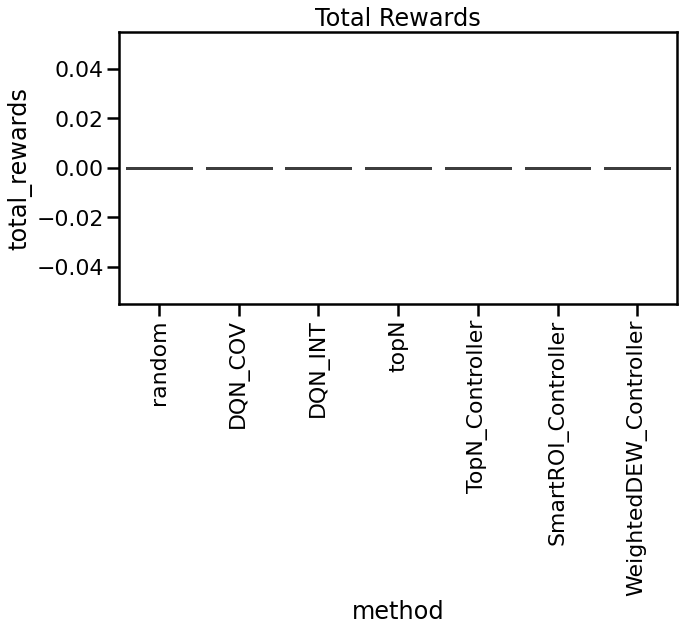

In [23]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='total_rewards')
plt.xticks(rotation=90)
plt.title('Total Rewards')

Text(0.5, 1.0, 'Coverage Proportion')

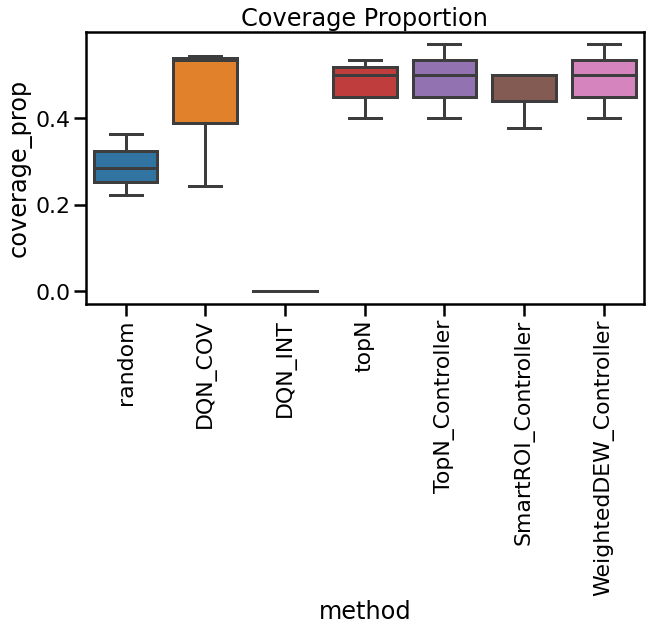

In [24]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='coverage_prop')
plt.xticks(rotation=90)
plt.title('Coverage Proportion')

Text(0.5, 1.0, 'Intensity Proportion')

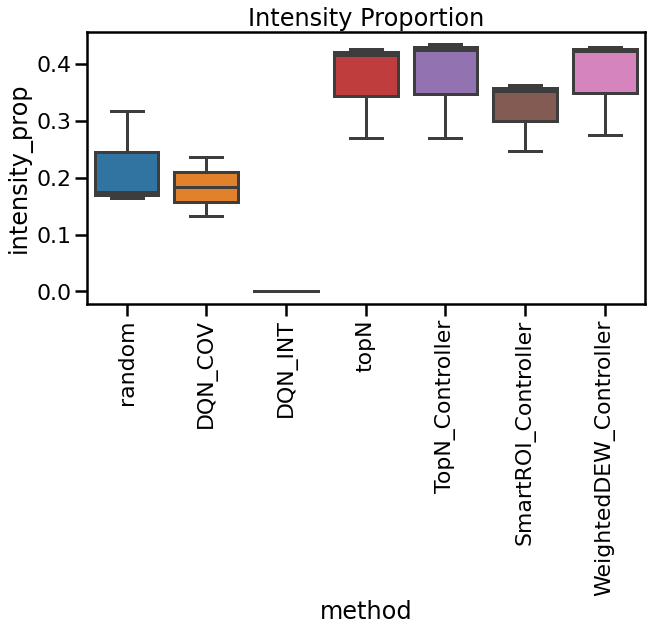

In [25]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='intensity_prop')
plt.xticks(rotation=90)
plt.title('Intensity Proportion')

Text(0.5, 1.0, 'MS1/MS2 Ratio')

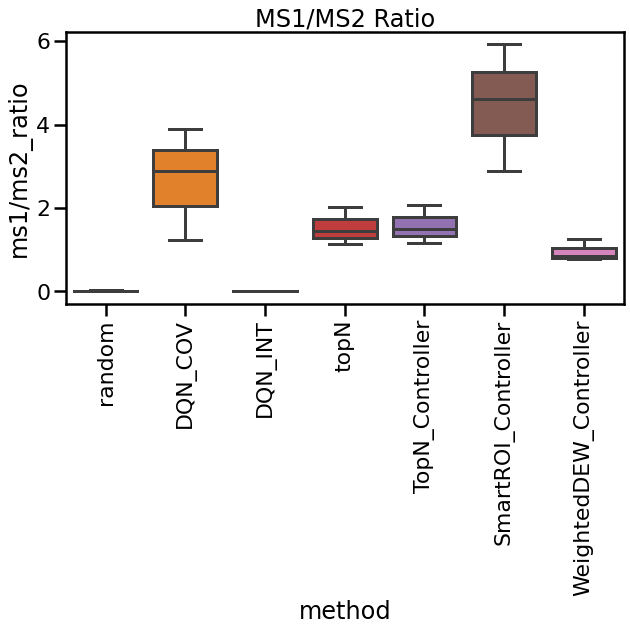

In [26]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='ms1/ms2_ratio')
plt.xticks(rotation=90)
plt.title('MS1/MS2 Ratio')

Text(0.5, 1.0, 'Efficiency')

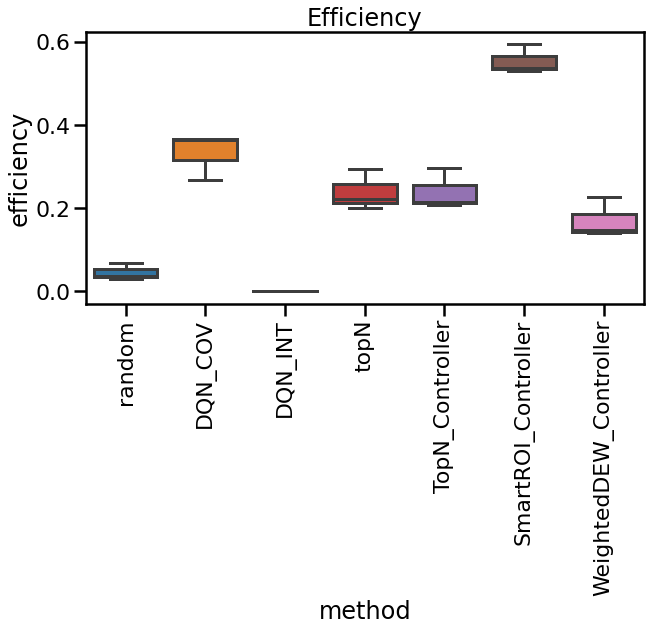

In [27]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='efficiency')
plt.xticks(rotation=90)
plt.title('Efficiency')

Text(0.5, 1.0, 'Precision')

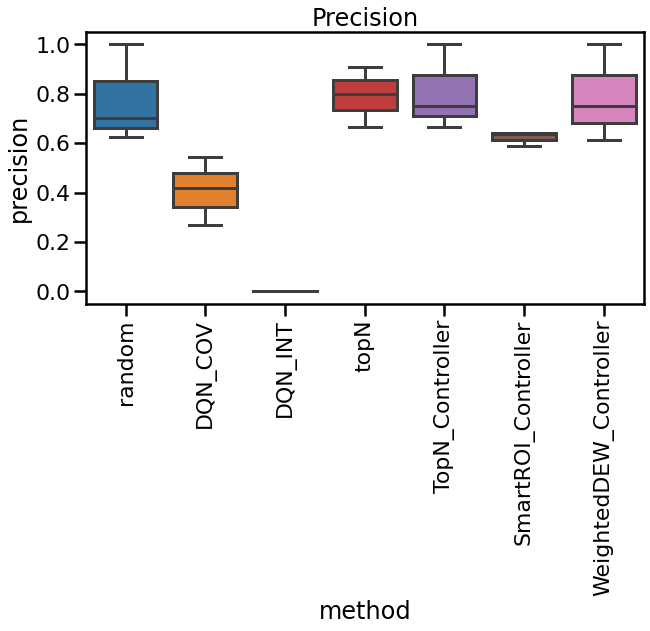

In [28]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='precision')
plt.xticks(rotation=90)
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

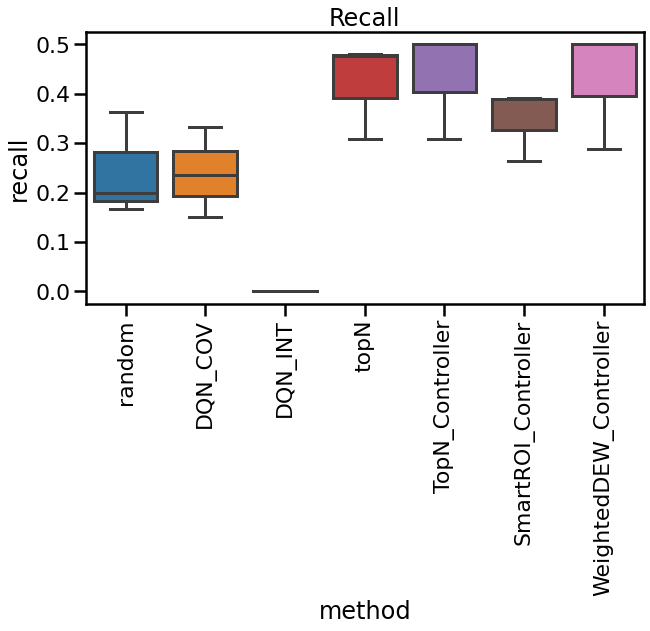

In [29]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='recall')
plt.xticks(rotation=90)
plt.title('Recall')

Text(0.5, 1.0, 'F1')

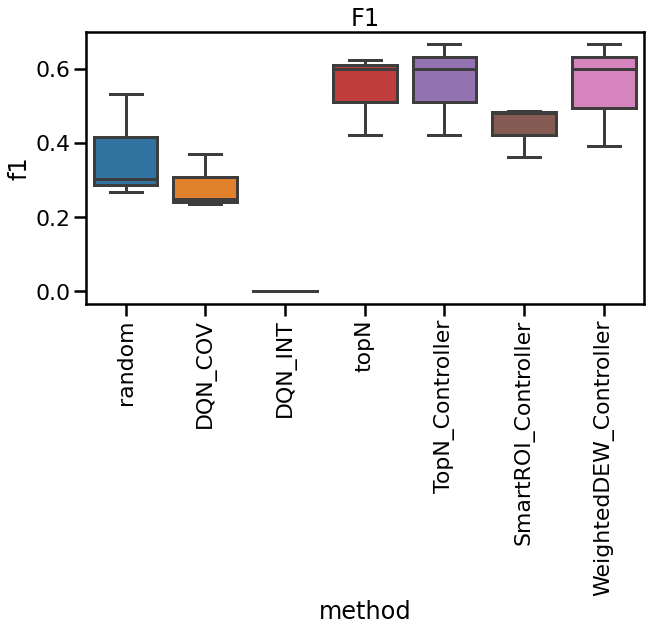

In [30]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='f1')
plt.xticks(rotation=90)
plt.title('F1')

In [31]:
df.to_pickle('evaluation.p')

### Without 'random'

In [32]:
df = pd.read_pickle('evaluation.p')

In [33]:
new_df = df[df.method != 'random']
new_df.head()

,method,total_rewards,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
3,DQN_COV,0.0,0.536,0.183,2.892,0.365,0.267,0.235,0.250
4,DQN_COV,0.0,0.545,0.236,3.895,0.368,0.417,0.333,0.370
5,DQN_COV,0.0,0.244,0.133,1.228,0.269,0.545,0.150,0.235
6,DQN_INT,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,DQN_INT,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000


Text(0.5, 1.0, 'Total Rewards')

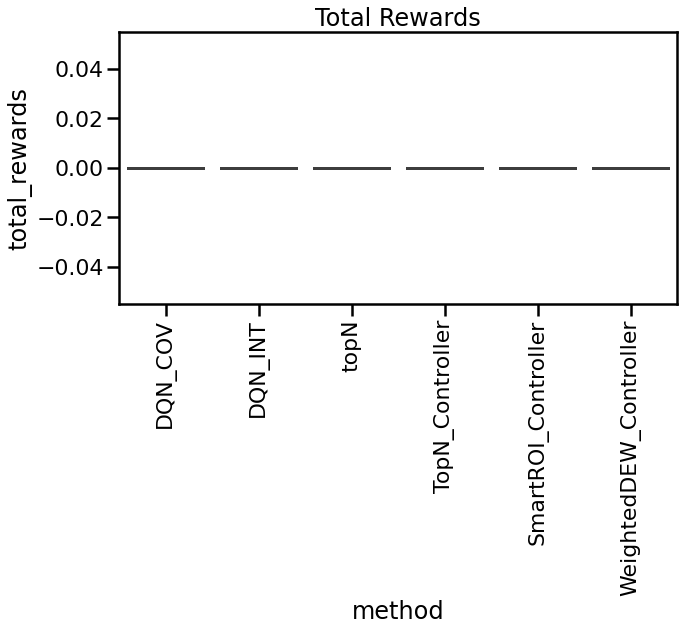

In [34]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='total_rewards', showfliers=False)
plt.xticks(rotation=90)
plt.title('Total Rewards')

Text(0.5, 1.0, 'Coverage Proportion')

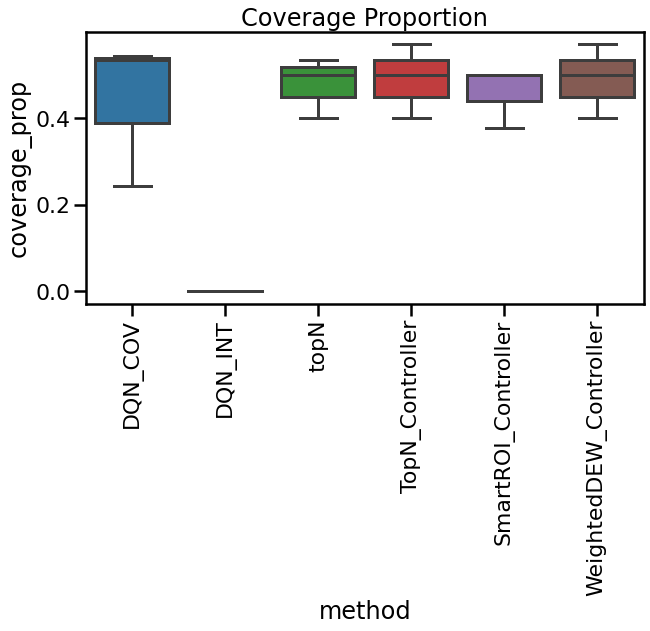

In [35]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='coverage_prop')
plt.xticks(rotation=90)
plt.title('Coverage Proportion')

Text(0.5, 1.0, 'Intensity Proportion')

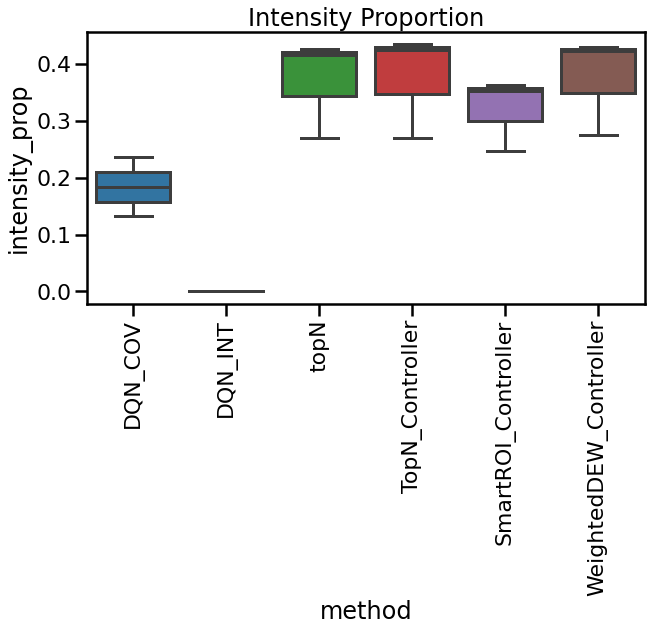

In [36]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='intensity_prop')
plt.xticks(rotation=90)
plt.title('Intensity Proportion')

Text(0.5, 1.0, 'MS1/MS2 Ratio')

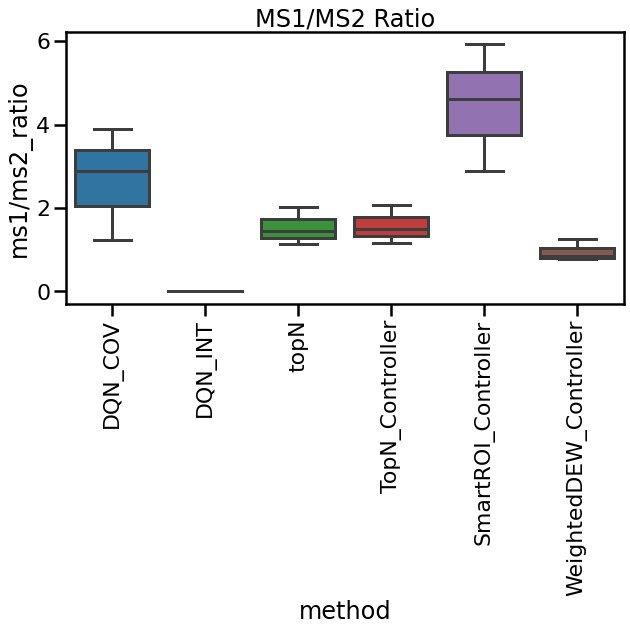

In [37]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='ms1/ms2_ratio')
plt.xticks(rotation=90)
plt.title('MS1/MS2 Ratio')

Text(0.5, 1.0, 'Precision')

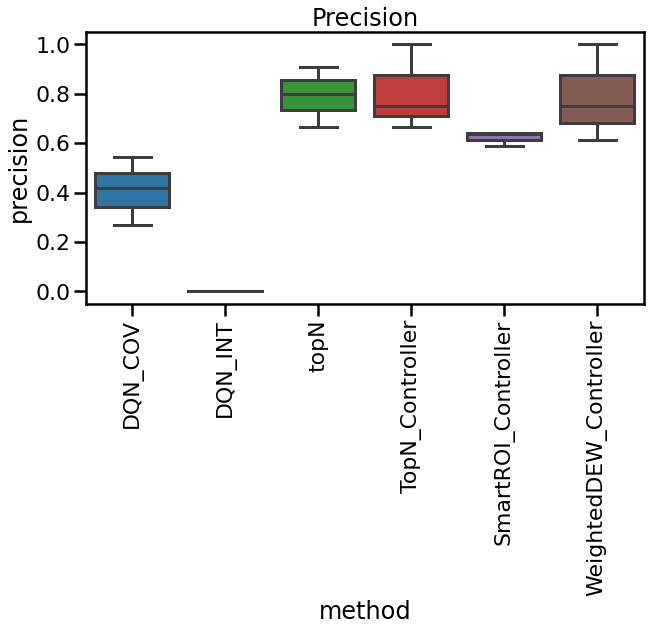

In [38]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='precision')
plt.xticks(rotation=90)
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

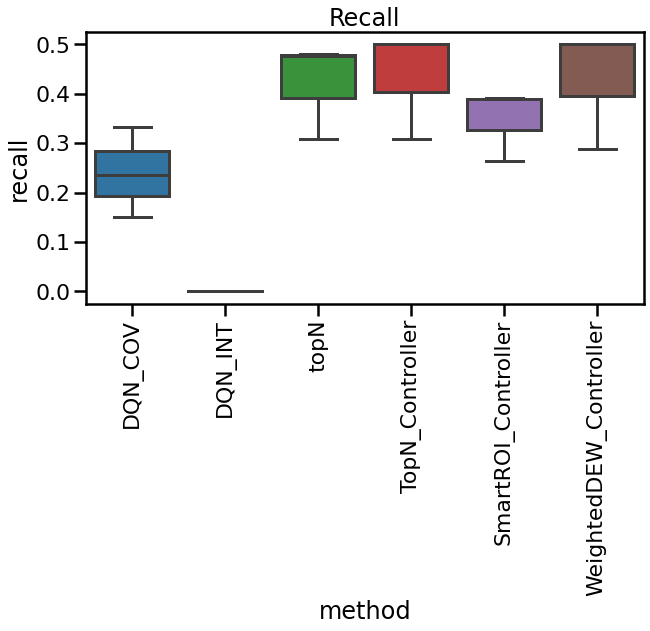

In [39]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='recall')
plt.xticks(rotation=90)
plt.title('Recall')

Text(0.5, 1.0, 'F1')

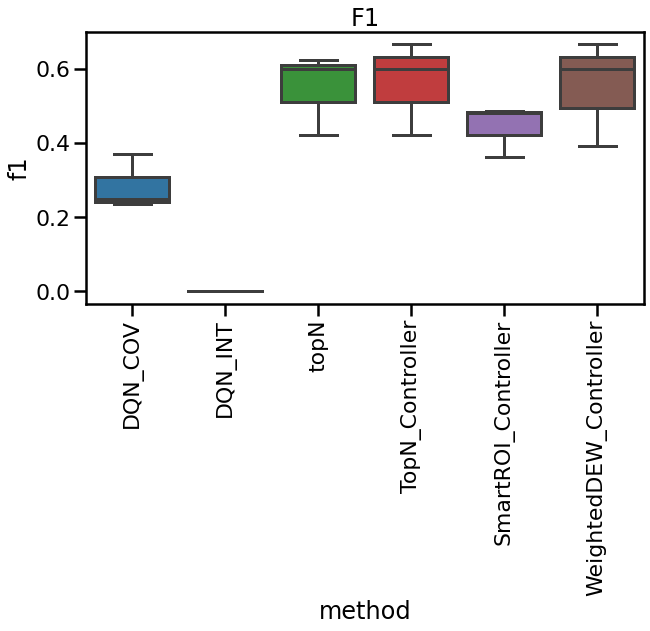

In [40]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='f1')
plt.xticks(rotation=90)
plt.title('F1')